Изучите удержание игроков «Королевства гномов» в динамике. Используя таблицу динамики удержания, постройте графики истории изменений удержания на конец первой и второй недели «жизни» пользователей по каждому источнику привлечения (channel) с разбивкой на платящих и неплатящих (payer).

In [1]:
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time


In [3]:
users = pd.read_csv('C:\\Users\\37544\\Downloads\\ch02_problems02_users.csv')   # профили
visits = pd.read_csv('C:\\Users\\37544\\Downloads\\ch02_problems02_visits.csv') # сессии

In [4]:
# преобразование данных о времени
users['dt'] = pd.to_datetime(users['dt']).dt.date
users['first_ts'] = pd.to_datetime(users['first_ts'])
visits['session_start'] = pd.to_datetime(visits['session_start'])

In [5]:
observation_date = users['dt'].max()  # момент анализа

analysis_horizon = 14  # горизонт анализа

In [6]:
retention_raw, retention, retention_history = get_retention(users, visits, observation_date, analysis_horizon, dimensions=['channel'])# получите сырые данные, таблицу удержания и таблицу динамики удержания

In [7]:
plt.figure(figsize = (20, 8))  # размер сетки для графиков                        

report = retention_history[[6, 13]]# сделайте срез таблицы динамики удержания

num_rows = len(users['payer'].unique())# задайте количество строк в таблице графиков
num_cols = len(users['channel'].unique())# задайте количество столбцов в таблице графиков

<Figure size 2000x800 with 0 Axes>

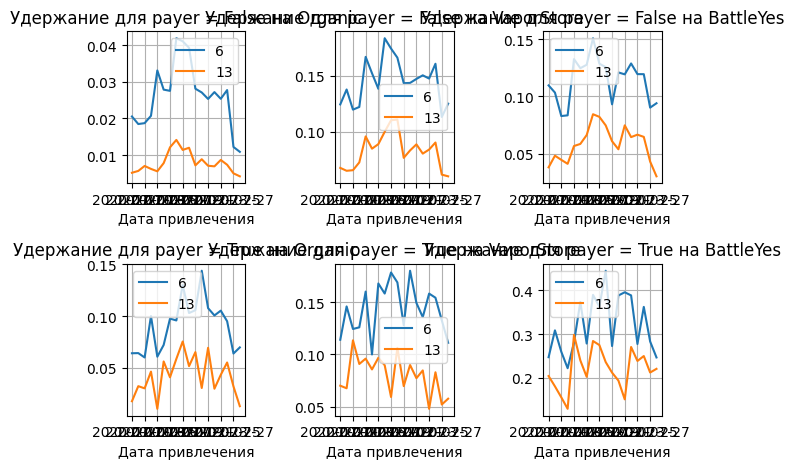

In [8]:
for i, payer in enumerate(users['payer'].unique()):
    for j, channel in enumerate(users['channel'].unique()):
        (
            report.query('payer == @payer and channel == @channel')
            .droplevel(['payer', 'channel'])
            .plot(
                grid=True,
                ax=plt.subplot(num_rows, num_cols, i * num_cols + j + 1),
            )
        )
        plt.xlabel('Дата привлечения')
        plt.title('Удержание для payer = {} на {}'.format(payer, channel))

plt.tight_layout()
plt.show()